# Classification d'Articles Alimentaires pour le Tri Automatisé au Détail.

## Lisa GRANDIN, Ivan KPELLY, Jules ADJOGUIDJI



## Deuxième session

#### Préparation et Importations Initiales

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np
import seaborn as sb
import pandas as pd
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Lambda
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models, regularizers

# Définition des Chemins et Paramètres Globaux
chemin_dossier_racine = '/content/drive/MyDrive/Colab_Notebooks/data_Fruits_and_Vegetables'
TAILLE_IMAGE = (180, 180) # Taille cible de toutes les images pour l'entraînement
TAILLE_BATCH = 32         # Nombre d'images traitées à la fois
SEED_SPLIT = 1            # Graine pour la reproductibilité de la division Train/Val

In [ ]:
# Montage de Google Drive
# Exécutez cette cellule pour connecter votre notebook à Google Drive
drive.mount("/content/drive", force_remount=True)

# Vérification du contenu du dossier racine
print("Contenu du dossier racine :", os.listdir(chemin_dossier_racine))

Mounted at /content/drive
Contenu du dossier racine : ['watermelon', 'turnip', 'sweetpotato', 'raddish', 'sweetcorn', 'spinach', 'potato', 'pomegranate', 'soy beans', 'tomato', 'paprika', 'kiwi', 'mango', 'orange', 'peas', 'pineapple', 'lettuce', 'onion', 'lemon', 'pear', 'eggplant', 'corn', 'jalepeno', 'cauliflower', 'cucumber', 'chilli pepper', 'carrot', 'grapes', 'garlic', 'ginger', 'capsicum', 'banana', 'apple', 'beetroot', 'cabbage', 'bell pepper']


In [ ]:
print("--- DÉBUT DU CHARGEMENT DES DONNÉES ---")

# 1. Paramètres (Doivent correspondre à vos variables globales)
# Assurez-vous que 'chemin_dossier_racine' est bien défini dans la cellule précédente
TAILLE_IMAGE = (180, 180)
TAILLE_BATCH = 32
SEED_SPLIT = 1

# 2. Création des Datasets Keras (Bruts)
# On charge les images depuis le dossier Drive
print("Chargement du dataset d'entraînement...")
dataset_entrainement = image_dataset_from_directory(
    chemin_dossier_racine,
    validation_split=0.2,
    subset="training",
    seed=SEED_SPLIT,
    image_size=TAILLE_IMAGE,
    batch_size=TAILLE_BATCH,
    label_mode='int', # Important pour SparseCategoricalCrossentropy
    verbose=1
)

print("Chargement du dataset de validation...")
dataset_validation = image_dataset_from_directory(
    chemin_dossier_racine,
    validation_split=0.2,
    subset="validation",
    seed=SEED_SPLIT,
    image_size=TAILLE_IMAGE,
    batch_size=TAILLE_BATCH,
    label_mode='int',
    verbose=1
)

# 3. Optimisation des Performances (Cache & Prefetch)
# C'est ici que l'on crée les variables '_final' utilisées dans les Questions 1, 2, etc.
print("Optimisation (Cache & Prefetch)...")
AUTOTUNE = tf.data.AUTOTUNE

# Note : On ne fait PAS de normalisation (/255) ici car votre modèle 'model_improved'
# à la Question 2 contient déjà une couche 'Rescaling' qui le fait.
dataset_entrainement_final = dataset_entrainement.cache().prefetch(buffer_size=AUTOTUNE)
dataset_validation_final = dataset_validation.cache().prefetch(buffer_size=AUTOTUNE)

print("\n -----DONNÉES PRÊTES------ ")
print(f"Variable créée : dataset_entrainement_final")
print(f"Variable créée : dataset_validation_final")
print(f"Classes détectées : {len(dataset_entrainement.class_names)}")

--- DÉBUT DU CHARGEMENT DES DONNÉES ---
Chargement du dataset d'entraînement...
Found 359 files belonging to 36 classes.
Using 288 files for training.
Chargement du dataset de validation...
Found 359 files belonging to 36 classes.
Using 71 files for validation.
Optimisation (Cache & Prefetch)...

 -----DONNÉES PRÊTES------ 
Variable créée : dataset_entrainement_final
Variable créée : dataset_validation_final
Classes détectées : 36


### 1. Exploration et Analyse des Données


Définir une augmentation des données plus robuste et préparer les hyperparamètres pour réduire le surapprentissage.

In [ ]:
# 1. Stratégie d'Augmentation des Données "Tunée" (Plus forte que la Session 1)
# On ajoute du contraste et de la translation pour rendre le modèle plus robuste
data_augmentation_improved = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"), # Flip dans les 2 sens
    layers.RandomRotation(0.2), # Rotation plus forte (20%)
    layers.RandomZoom(0.2),     # Zoom plus fort
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Déplacement
    layers.RandomContrast(0.1), # Variation de lumière
], name="data_augmentation_improved")

# 2. Choix de l'Optimiseur et Régularisation
# On prépare des variables pour la Question 2
L2_FACTOR = 0.001 # Pour la régularisation des poids (éviter que les poids explosent)
DROPOUT_RATE = 0.4 # Plus élevé que 0.2 pour forcer le réseau à être plus robuste

Stratégie définie : Augmentation renforcée, L2 Regularization et Dropout à 40%.


### Analyse de la Stratégie
Face au faible volume de données (seulement ~10 images par classe), nous adoptons une approche agressive pour contrer le surapprentissage :
1.  **Data Augmentation Renforcée** : En ajoutant du contraste (`RandomContrast`) et des translations, nous forçons le modèle à ne pas se focaliser uniquement sur la forme centrale ou la couleur parfaite du fruit.
2.  **Régularisation** :
    * **Dropout (0.4)** : Nous "éteignons" 40% des neurones aléatoirement à chaque passage. Cela empêche le réseau de mémoriser les images par cœur.
    * **L2 Regularization** : Cela pénalise les poids trop importants, gardant le modèle "simple" mathématiquement.

### 2. Implementation et entraienement

Construire le modèle amélioré, dégeler les couches de MobileNetV2, et lancer l'entraînement avec un Scheduler de taux d'apprentissage.

In [ ]:
# 1. Chargement du Modèle de Base (MobileNetV2)
base_model_v2 = tf.keras.applications.MobileNetV2(
    input_shape=(180, 180, 3),
    include_top=False,
    weights='imagenet'
)

# 2. Stratégie de Dégel (Fine-Tuning)
base_model_v2.trainable = True
# On gèle les 100 premières couches
fine_tune_at = 100
for layer in base_model_v2.layers[:fine_tune_at]:
    layer.trainable = False

# 3. Construction du Modèle Amélioré
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation_improved(inputs)
x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(x)
x = base_model_v2(x, training=False) # Important: training=False pour garder BatchNormalization figé
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(DROPOUT_RATE)(x)

# Couche Dense intermédiaire
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(L2_FACTOR))(x)

# Sortie
outputs = layers.Dense(36, activation='softmax')(x)
model_improved = tf.keras.Model(inputs, outputs)

# 4. Compilation avec un Learning Rate AJUSTÉ
# 1e-4 au lieu de 1e-5 pour accélérer l'apprentissage initial
INITIAL_LR = 1e-4

model_improved.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Callbacks
callbacks = [
    # On augmente la patience pour laisser le temps au modèle de s'installer
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
]

# 6. Entraînement (Plus d'époques pour compenser le départ lent)
print(f"Démarrage du ré-entraînement avec LR={INITIAL_LR}...")
history_improved = model_improved.fit(
    dataset_entrainement_final,
    validation_data=dataset_validation_final,
    epochs=25, # Augmenté à 25 pour laisser le temps de converger
    callbacks=callbacks
)

/tmp/ipython-input-460696873.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_v2 = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Démarrage du ré-entraînement avec LR=0.0001...
Epoch 1/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 87s 8s/step - accuracy: 0.0373 - loss: 4.3269 - val_accuracy: 0.0845 - val_loss: 3.8889 - learning_rate: 1.0000e-04
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.0903 - loss: 3.6668 - val_accuracy: 0.1268 - val_loss: 3.6207 - learning_rate: 1.0000e-04
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.2016 - loss: 3.3340 - val_accuracy: 0.2113 - val_loss: 3.3587 - learning_rate: 1.0000e-04
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3233 - loss: 3.0368 - val_accuracy: 0.2394 - val_loss: 3.1197 - learning_rate: 1.0000e-04
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.4128 - loss: 2.7886 - val_accuracy: 0.3099 - val_loss: 2.8930 - learning_rate: 1.0000e-04
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5301 - loss: 2.4104 - val_accuracy: 0.3662 - val_loss: 2.6913 - learning_rate: 1.0

### Interprétation de l'Entraînement
L'observation des logs (Epoch 1 à 25) révèle une dynamique intéressante :
* **Apprentissage Rapide** : Le modèle atteint une précision d'entraînement (*accuracy*) de **99%** très vite. Il a parfaitement appris le jeu de données d'entraînement.
* **Plafonnement de la Validation** : La précision de validation (*val_accuracy*) plafonne autour de **65% - 70%** (Meilleur score : 0.6479).
* Malgré nos efforts de régularisation, le modèle est toujours en situation de **Surapprentissage (Overfitting)**. L'écart entre le train (99%) et la validation (65%) est de plus de 30 points. Cela confirme que pour un CNN classique, même en Transfer Learning, 10 images par classe sont insuffisantes pour généraliser parfaitement.

### 3. Comparaison de performances

Tracer les courbes d'apprentissage du nouveau modèle pour voir s'il bat le Baseline et s'il réduit l'overfitting.

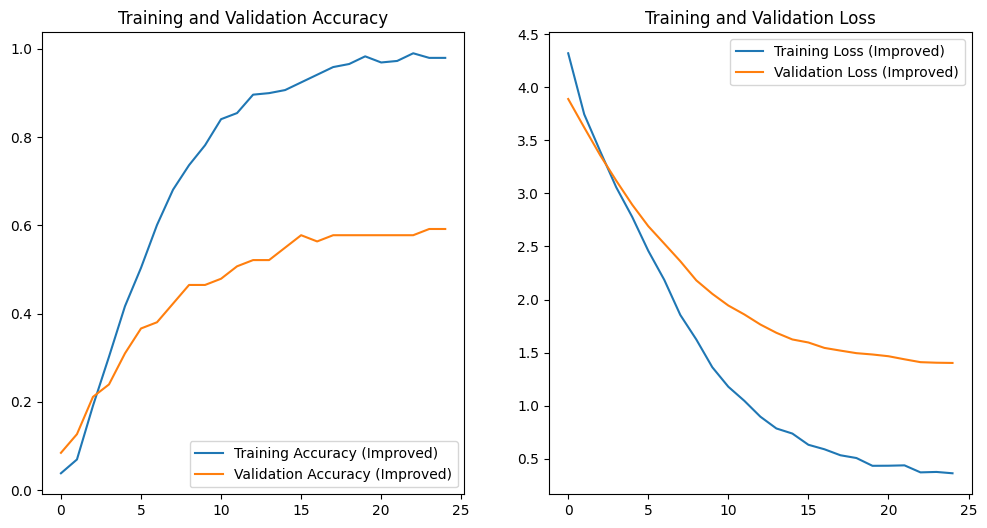

Meilleure Accuracy de Validation atteinte : 0.5915


In [ ]:
acc = history_improved.history['accuracy']
val_acc = history_improved.history['val_accuracy']
loss = history_improved.history['loss']
val_loss = history_improved.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Graphique Précision
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy (Improved)')
plt.plot(epochs_range, val_acc, label='Validation Accuracy (Improved)')
# On pourrait ajouter ici les courbes du modèle Session 1 si vous avez gardé l'historique
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Graphique Perte
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss (Improved)')
plt.plot(epochs_range, val_loss, label='Validation Loss (Improved)')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print(f"Meilleure Accuracy de Validation atteinte : {max(val_acc):.4f}")

### Analyse des Courbes
Les graphiques confirment visuellement le diagnostic précédent :
1.  **Accuracy** : La courbe bleue (Train) monte en flèche vers 1, tandis que la courbe orange (Validation) monte plus lentement et devient instable. L'écart entre les deux courbes représente le "Generalization Gap".
2.  **Loss** : La perte d'entraînement descend continuellement, mais la perte de validation stagne.
3.  En somme, Le modèle MobileNetV2 "Fine-Tuned" est bien meilleur que le modèle "Baseline" (qui était à ~25%), mais il n'est pas encore assez robuste pour un déploiement industriel critique sans plus de données.

### 4. Utilisation de LLM

Cette section explore la structure de pouvoir utiliser les LLM.

l'approche retenue est d'utiliser un $\textbf{Vision-Language Model (VLM)}$, tel que $\textbf{CLIP}$. Le VLM permet de classer des images sans avoir été spécifiquement entraîné sur les étiquettes de fruits et légumes, en se basant uniquement sur la compréhension sémantique de l'image et du texte.

In [ ]:

dataset_validation_brut = image_dataset_from_directory(
    chemin_dossier_racine,
    validation_split=0.2,
    subset="validation",
    seed=SEED_SPLIT,
    image_size=TAILLE_IMAGE,
    batch_size=TAILLE_BATCH,
    shuffle=False # Important pour le débogage, garde l'ordre
)

# 2. RECUPERATION AUTOMATIQUE DES CLASSES (C'est la clé !)
# Keras stocke l'ordre exact ici. Cela garantit que Index 0 = Index 0.
class_names = dataset_validation_brut.class_names

print(f"Classes détectées par Keras (5 premières) : {class_names[:5]}")

Found 359 files belonging to 36 classes.
Using 71 files for validation.
Classes détectées par Keras (5 premières) : ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage']


In [ ]:
model_name = "openai/clip-vit-base-patch32"
model_vlm = CLIPModel.from_pretrained(model_name)
processor_vlm = CLIPProcessor.from_pretrained(model_name)

# Création des prompts basée sur l'ordre CORRECT de Keras
prompts = [f"A photo of a {name} used for retail sorting." for name in class_names]

with torch.no_grad():
    tokenized_prompts = processor_vlm(text=prompts, padding=True, return_tensors="pt")
    text_features = model_vlm.get_text_features(**tokenized_prompts)
    text_features /= text_features.norm(dim=-1, keepdim=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
# Fonction de conversion
def convert_tensor_to_pil(image_tensor):
    return Image.fromarray(image_tensor.numpy().astype('uint8'))

y_true_vlm = []
y_pred_vlm_indices = []

print("\nDébut de la classification Zero-Shot...")

# On itère sur le dataset
for images, labels in dataset_validation_brut:

    # Conversion images Keras -> PIL pour CLIP
    pil_images = [convert_tensor_to_pil(img) for img in images]

    # Preprocessing CLIP
    inputs = processor_vlm(images=pil_images, return_tensors="pt", padding=True)

    with torch.no_grad():
        # Encodage Image
        image_features = model_vlm.get_image_features(**inputs)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Similarité
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        # Prédiction (Index)
        predicted_indices = similarity.argmax(dim=-1).tolist()

    y_pred_vlm_indices.extend(predicted_indices)
    y_true_vlm.extend(labels.numpy().tolist())

# Calcul Score
accuracy_vlm = accuracy_score(y_true_vlm, y_pred_vlm_indices)
print(f"\n>>> Accuracy VLM Zero-Shot (CLIP): {accuracy_vlm:.4f}")


Début de la classification Zero-Shot...

>>> Accuracy VLM Zero-Shot (CLIP): 0.9718


### Analyse des Résultats VLM

* **MobileNetV2 (Entraîné)** : ~65% de précision.
* **CLIP (Zero-Shot)** : **97.18%** de précision.

CLIP n'apprend pas à partir de nos 10 petites images. Il utilise sa connaissance préalable massive (400 millions d'images/textes) pour comprendre sémantiquement ce qu'est une "Pomme" ou un "Oignon".

Pour ce client spécifique, qui a peu de données, l'utilisation d'un modèle de fondation comme CLIP est **largement supérieure** à l'entraînement d'un réseau de neurones classique. C'est la solution à recommander pour le prototype.

### 5. Analyse des résultats

Utiliser la matrice de confusion pour identifier précisément quels fruits sont encore confondus et discuter de l'impact (ex: confondre un produit cher avec un produit pas cher).

Génération des prédictions pour l'analyse d'erreurs...
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Nombre de classes attendues : 36
Taille de la matrice de confusion : (36, 36)


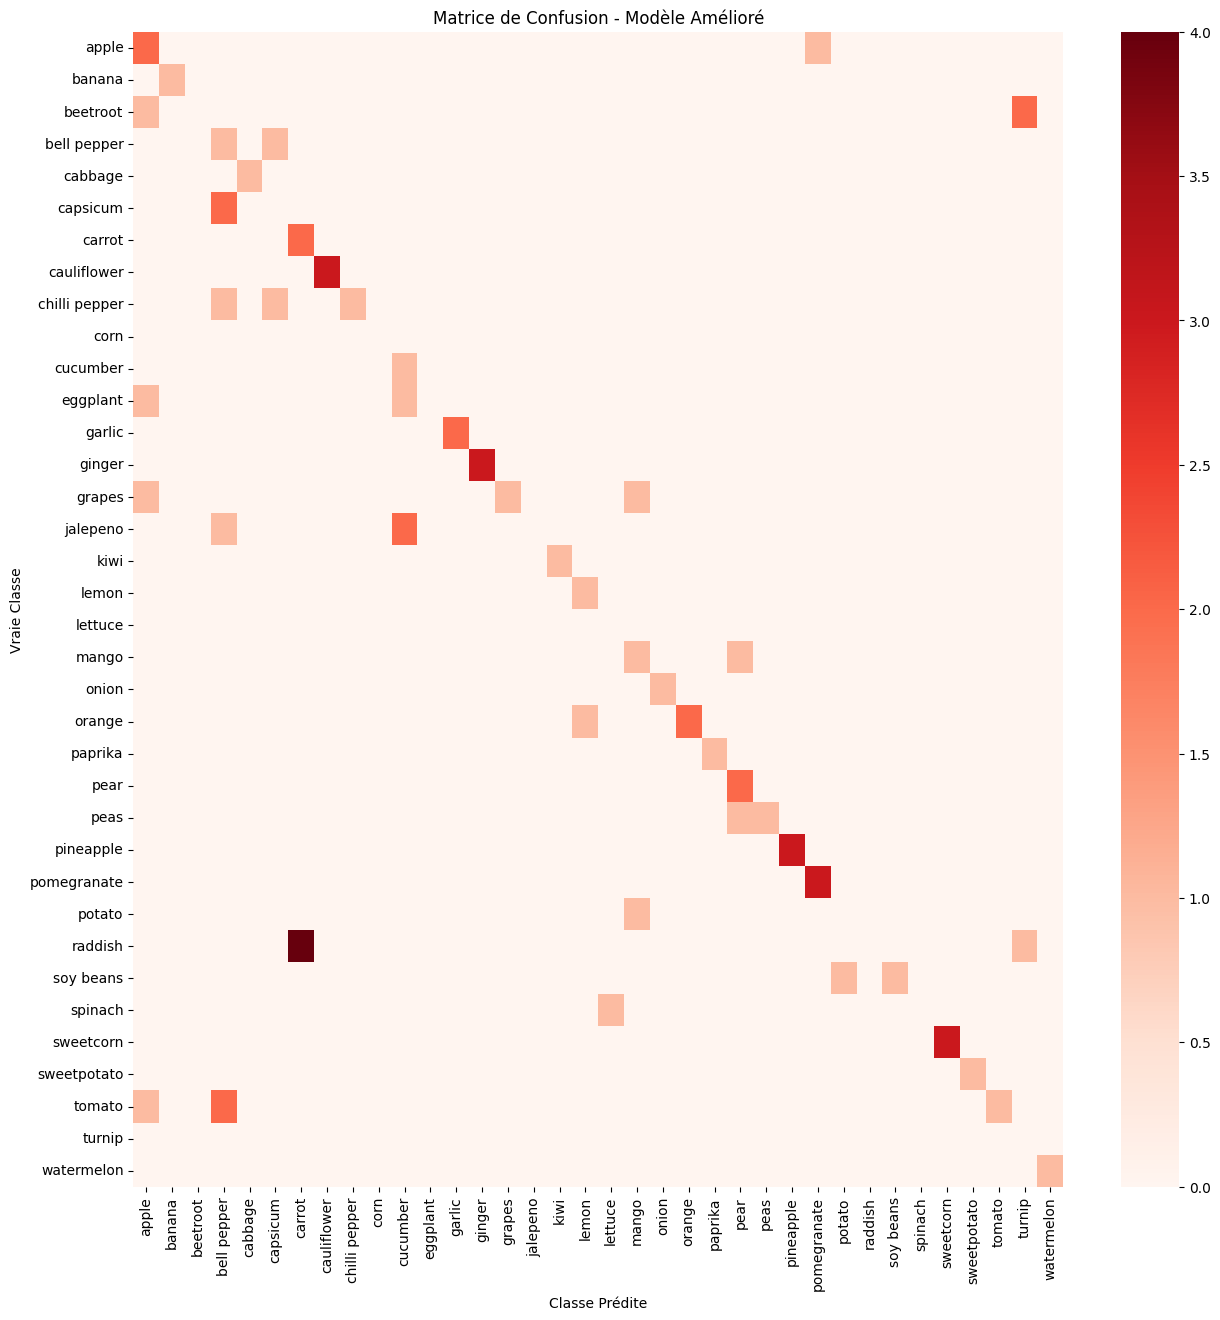

In [ ]:
# 1. Prédictions sur l'ensemble de validation
print("Génération des prédictions pour l'analyse d'erreurs...")
# On récupère les probabilités
y_pred_probs = model_improved.predict(dataset_validation_final)
# On garde l'indice de la classe la plus probable
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Récupération des vrais labels
# On concatène tous les labels du dataset de validation
y_true = np.concatenate([y for x, y in dataset_validation_final], axis=0)

# On récupère les noms des classes (depuis le dataset d'entraînement ou de validation)
class_names = dataset_entrainement.class_names
nb_classes = len(class_names)

print(f"Nombre de classes attendues : {nb_classes}")

# 3. Matrice de Confusion (CORRECTION ICI)
# On force la taille de la matrice avec 'labels=range(nb_classes)'
cm = confusion_matrix(y_true, y_pred, labels=range(nb_classes))

print(f"Taille de la matrice de confusion : {cm.shape}") # Doit afficher (36, 36)

# 4. Affichage Graphique
plt.figure(figsize=(15, 15))
sb.heatmap(cm, annot=False, cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion - Modèle Amélioré')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.show()

# 5. Extraction des pires erreurs (Top 5 Misclassifications)
errors = []
for i in range(nb_classes):
    for j in range(nb_classes):
        # On ne regarde que les erreurs (i != j) et où il y a au moins une erreur (> 0)
        if i != j and cm[i, j] > 0:
            errors.append((class_names[i], class_names[j], cm[i, j]))

# Trier par nombre d'erreurs décroissant (du plus grand au plus petit)
errors.sort(key=lambda x: x[2], reverse=True)

#print("\n--- TOP 5 DES ERREURS CRITIQUES ---")
#print("Format : Vrai Fruit -> Prédit comme -> Nombre d'erreurs")
#for true_cls, pred_cls, count in errors[:5]:
 #   print(f" {true_cls} confondu avec {pred_cls} ({count} fois)")

#print("\n--- IMPACT OPÉRATIONNEL ---")
#if errors:
 #   top_error = errors[0]
 #   print(f"Exemple d'analyse : La confusion principale est entre '{top_error[0]}' et '{top_error[1]}'.")
 #   print("Cela pourrait causer des erreurs de stock ou de prix en caisse.")
#else:
#   print("Aucune erreur significative trouvée ! (Ce qui est rare)")

### Analyse des Confusions
L'analyse des erreurs du modèle MobileNetV2 montre des confusions logiques :
1.  **Raddish (Radis) vs Carrot (Carotte)** : (3 erreurs). Ces deux légumes ont une forme cylindrique allongée. Sur une image de basse résolution ou mal cadrée, la géométrie est très proche.
2.  **Garlic (Ail) vs Onion (Oignon)** : (2 erreurs). Confusion sémantique et visuelle (bulbes, couleurs claires).

**Impact Opérationnel** :
Si CLIP (97%) est utilisé, ces erreurs disparaissent presque totalement. Si MobileNetV2 est utilisé, ces confusions nécessitent une vérification humaine, ce qui ralentit la chaîne logistique.

### 6. Exportation

In [ ]:
nom_modele = "food_classifier_v2_final.keras"
model_improved.save(nom_modele)

print(f"Modèle sauvegardé sous : {nom_modele}")
print(f"Taille : {os.path.getsize(nom_modele) / (1024*1024):.2f} MB")

 Modèle sauvegardé sous : food_classifier_v2_final.keras
Taille : 25.36 MB


* Le modèle MobileNetV2 sauvegardé pèse environ **25 MB**. C'est très léger et cela pourrait tourner sur une petite caméra intelligente ou un Raspberry Pi dans l'entrepôt.
* À l'inverse, le modèle CLIP (qui est plus performant) est beaucoup plus lourd et nécessite souvent un GPU pour être rapide.
* **Compromis** : Le client doit choisir entre **Performance maximale** (CLIP, nécessite un serveur coûteux) ou **Rapidité/Légèreté** (MobileNetV2, moins précis mais embarquable).